原始数据形状: (10980, 16)
IPCC区域地理数据加载成功
正在为岛屿分配IPCC区域...
区域分配完成，涉及区域: 43

=== 筛选在Climate Stress和TP2050之间有分类变化的岛屿 ===
满足数量阈值的有效区域 (岛屿数量>10): 39 个
有效区域内的岛屿数: 1825
=== 使用统一的output_0中位数基准进行所有情景的分类 ===
全局基准 - 盈亏平衡电价中位数: 0.197
全局基准 - 可负担电价中位数: 0.146
情景 output_2050: 有效岛屿数 1826
情景 output_future_2030: 有效岛屿数 1826
情景 output_future_2040: 有效岛屿数 1826
情景 output_future_2050: 有效岛屿数 1826
四个情景共同存在的岛屿数量: 1825
在Climate Stress和TP2050之间发生分类变化的岛屿数量: 47
最终用于桑基图的岛屿数: 47

=== 最终桑基图数据摘要 ===
桑基图数据准备完成，包含 47 个岛屿
涉及区域: 8 个
区域列表: ['EAS', 'MED', 'NZ', 'SAS', 'SAU', 'SCA', 'SEA', 'SWS']

=== 筛选过程摘要 ===
1. 满足区域数量阈值的岛屿: 1825
2. 四个情景共同存在的岛屿: 1825
3. Climate Stress和TP2050间有变化的岛屿: 47
4. 最终桑基图岛屿数: 47
5. 最终涉及区域数: 8

各区域的变化岛屿分布:
  EAS: 3 个变化岛屿
  MED: 13 个变化岛屿
  NZ: 3 个变化岛屿
  SAS: 7 个变化岛屿
  SAU: 3 个变化岛屿
  SCA: 1 个变化岛屿
  SEA: 15 个变化岛屿
  SWS: 2 个变化岛屿


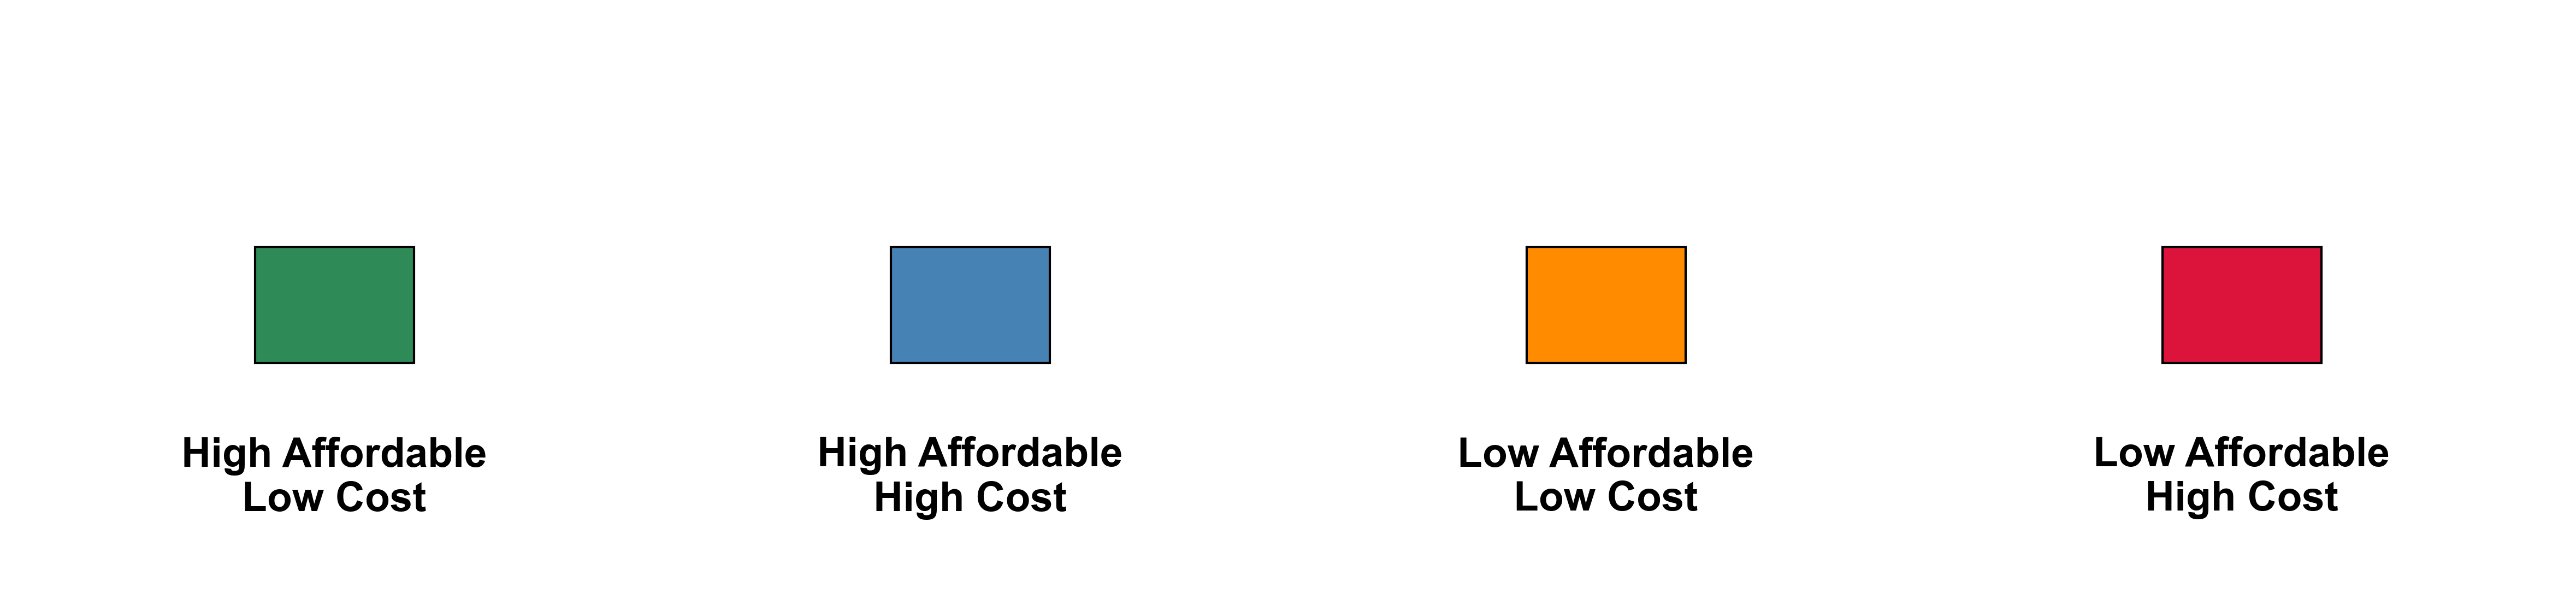

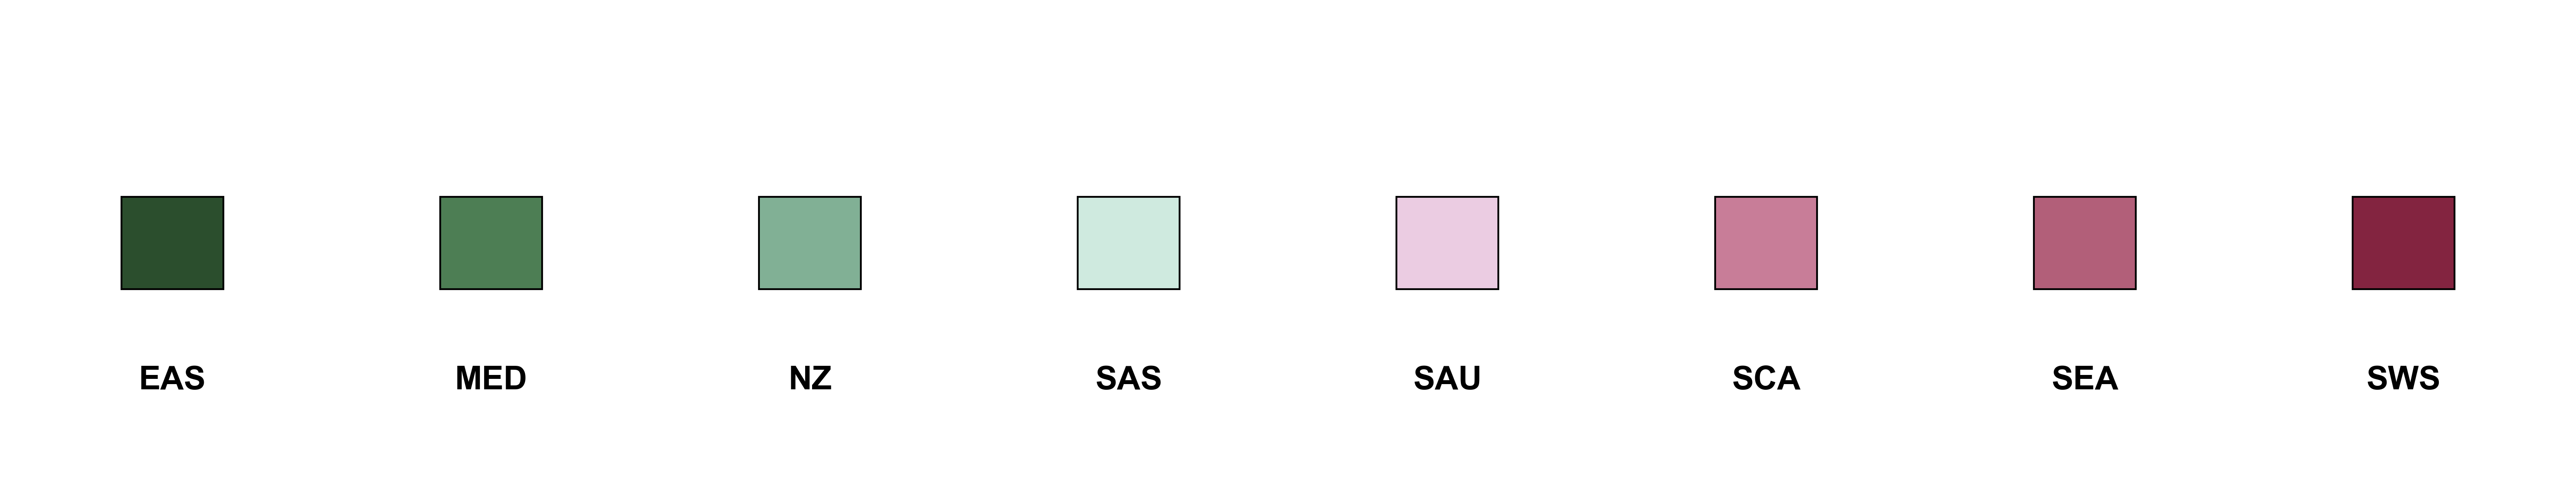

In [4]:
# 使用 floweaver 和 holoviews 创建五列连续桑基图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import matplotlib

# 设置全局字体为Arial
plt.rcParams.update({
    'font.family': 'Arial',  # 设置字体为Arial
    'font.size': 16,  # 基础字体大小
})

# =============================================================================
# 数据预处理部分 - 五个情景的五列桑基图数据准备
# =============================================================================

# 1. 读取岛屿可行性分析数据
data_path = Path("../result/island_viability_summary_electric.csv")
df = pd.read_csv(data_path)  # 加载原始数据
print(f"原始数据形状: {df.shape}")  # 显示数据维度信息

# 2. 加载IPCC区域地理数据用于区域分配
try:
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")  # 加载IPCC区域边界数据
    ipcc_regions.sindex  # 创建空间索引以加速地理查询
    print("IPCC区域地理数据加载成功")
except Exception as e:
    print(f"无法加载IPCC区域数据: {e}")
    ipcc_regions = None

# 3. 定义IPCC区域分配函数（高效版本）
def assign_ipcc_region_optimized(lat, lon, ipcc_regions_gdf):
    """使用空间索引高效地将坐标分配到IPCC区域"""
    point = Point(lon, lat)  # 创建点几何对象
    possible_matches_index = list(ipcc_regions_gdf.sindex.intersection(point.bounds))  # 空间索引快速筛选
    possible_matches = ipcc_regions_gdf.iloc[possible_matches_index]  # 获取可能匹配的区域
    precise_matches = possible_matches[possible_matches.contains(point)]  # 精确几何匹配
    if not precise_matches.empty:
        return precise_matches.iloc[0]['Acronym']  # 返回区域简称
    return 'Unknown'  # 未匹配到区域时返回Unknown

# 4. 定义变化计算函数（与上面cell保持一致）
def calculate_position_change(df_base, df_compare):
    """计算两个情景之间的位置变化 - 修正版，包含IPCC区域信息"""
    # 修正：合并时包含ipcc_region信息
    merged = pd.merge(df_base[['island_id', 'tariff_breakeven', 'ipcc_region']],
                      df_compare[['island_id', 'tariff_breakeven']],
                      on='island_id', suffixes=('_base', '_compare'))
    merged['position_change'] = abs(merged['tariff_breakeven_compare'] - merged['tariff_breakeven_base'])
    # 重命名ipcc_region列以保持一致性
    merged = merged.rename(columns={'ipcc_region': 'ipcc_region_base'})
    return merged

# 5. 为整个数据集分配IPCC区域（与上面cell保持一致）
if ipcc_regions is not None:
    print("正在为岛屿分配IPCC区域...")
    df['ipcc_region'] = df.apply(
        lambda row: assign_ipcc_region_optimized(row['lat'], row['lon'], ipcc_regions), axis=1
    )  # 应用区域分配函数
    print(f"区域分配完成，涉及区域: {df['ipcc_region'].nunique()}")
else:
    df['ipcc_region'] = 'Unknown'  # 如果没有区域数据，设为Unknown

# =============================================================================
# NEW: 筛选在Climate Stress和TP2050之间有分类变化的岛屿
# =============================================================================

print("\n=== 筛选在Climate Stress和TP2050之间有分类变化的岛屿 ===")

# 首先应用区域数量阈值
MIN_ISLANDS_PER_REGION = 10  # 每个区域最少岛屿数量阈值
region_counts = df['ipcc_region'].value_counts()  # 统计各区域岛屿数量
valid_regions = region_counts[region_counts > MIN_ISLANDS_PER_REGION].index.tolist()  # 筛选有效区域

print(f"满足数量阈值的有效区域 (岛屿数量>{MIN_ISLANDS_PER_REGION}): {len(valid_regions)} 个")

# 筛选有效区域的岛屿
df_valid_regions = df[df['ipcc_region'].isin(valid_regions)].copy()
print(f"有效区域内的岛屿数: {len(df_valid_regions['island_id'].unique())}")

# =============================================================================
# 7. 定义象限分类函数
# =============================================================================

def classify_quadrant(row, median_breakeven, median_affordable):
    """根据电价中位数将岛屿分类到四个象限"""
    breakeven = row['tariff_breakeven']  # 盈亏平衡电价
    affordable = row['tariff_affordable']  # 可负担电价

    if affordable > median_affordable and breakeven <= median_breakeven:
        return 'High Affordable\\nLow Cost'  # 高可负担性、低成本
    elif affordable > median_affordable and breakeven > median_breakeven:
        return 'High Affordable\\nHigh Cost'  # 高可负担性、高成本
    elif affordable <= median_affordable and breakeven <= median_breakeven:
        return 'Low Affordable\\nLow Cost'  # 低可负担性、低成本
    else:
        return 'Low Affordable\\nHigh Cost'  # 低可负担性、高成本

# =============================================================================
# 8. 处理五个情景的数据并计算统一的中位数分类基准
# =============================================================================

scenarios = ['output_2050', 'output_future_2030', 'output_future_2040', 'output_future_2050']  # 四个目标情景
scenario_labels = ['Climate Stress', 'TP2030', 'TP2040', 'TP2050']  # 情景标签

# 首先从output_0（Ideal情景）计算全局中位数基准
df_output_0 = df_valid_regions[df_valid_regions['scenario'] == 'output_0'].copy()  # 获取Ideal情景数据
global_median_breakeven = df_output_0['tariff_breakeven'].median()  # 全局盈亏平衡电价中位数
global_median_affordable = df_output_0['tariff_affordable'].median()  # 全局可负担电价中位数

print(f"=== 使用统一的output_0中位数基准进行所有情景的分类 ===")
print(f"全局基准 - 盈亏平衡电价中位数: {global_median_breakeven:.3f}")
print(f"全局基准 - 可负担电价中位数: {global_median_affordable:.3f}")

# 准备合并数据的列表
combined_data = []

# 为每个情景使用统一的全局中位数进行分类
for scenario in scenarios:
    df_scenario = df_valid_regions[df_valid_regions['scenario'] == scenario].copy()  # 筛选情景数据

    # 使用统一的全局中位数基准进行象限分类
    df_scenario['quadrant'] = df_scenario.apply(
        lambda row: classify_quadrant(row, global_median_breakeven, global_median_affordable), axis=1
    )  # 为每个岛屿分配象限，使用统一基准

    print(f"情景 {scenario}: 有效岛屿数 {len(df_scenario)}")
    combined_data.append(df_scenario)

# 找到四个情景中共同存在的岛屿
common_islands = set(combined_data[0]['island_id'])
for df_scenario in combined_data[1:]:
    common_islands = common_islands.intersection(set(df_scenario['island_id']))

print(f"四个情景共同存在的岛屿数量: {len(common_islands)}")

# 筛选共同岛屿的数据
for i in range(len(combined_data)):
    combined_data[i] = combined_data[i][combined_data[i]['island_id'].isin(common_islands)].copy()

# 识别在Climate Stress和TP2050之间发生分类变化的岛屿
changed_island_ids = []
df_climate = combined_data[0]  # Climate Stress
df_tp2050 = combined_data[3]   # TP2050

for island_id in common_islands:
    climate_class = df_climate[df_climate['island_id'] == island_id]['quadrant'].iloc[0]
    tp2050_class = df_tp2050[df_tp2050['island_id'] == island_id]['quadrant'].iloc[0]
    
    # 如果Climate Stress和TP2050的分类不同，就认为发生了变化
    if climate_class != tp2050_class:
        changed_island_ids.append(island_id)

print(f"在Climate Stress和TP2050之间发生分类变化的岛屿数量: {len(changed_island_ids)}")

# 最终筛选：只保留发生变化的岛屿
for i in range(len(combined_data)):
    combined_data[i] = combined_data[i][combined_data[i]['island_id'].isin(changed_island_ids)].copy()

final_island_count = len(changed_island_ids)
print(f"最终用于桑基图的岛屿数: {final_island_count}")

# =============================================================================
# 9. 创建五列桑基图的数据结构
# =============================================================================

def prepare_five_column_sankey_data(df_list):
    """为五列桑基图准备数据"""

    # 为发生变化的岛屿创建桑基图数据
    sankey_data = []

    for island_id in changed_island_ids:
        # 获取该岛屿在四个情景下的信息
        island_info = {}
        for i, df_scenario in enumerate(df_list):
            island_row = df_scenario[df_scenario['island_id'] == island_id].iloc[0]
            island_info[f'scenario_{i}'] = {
                'region': island_row['ipcc_region'],
                'quadrant': island_row['quadrant']
            }

        # 添加到桑基图数据
        sankey_data.append({
            'island_id': island_id,
            'region': island_info['scenario_0']['region'],  # 第一列：区域
            'climate_class': island_info['scenario_0']['quadrant'],  # 第二列：Climate Stress分类
            'tp2030_class': island_info['scenario_1']['quadrant'],   # 第三列：TP2030分类
            'tp2040_class': island_info['scenario_2']['quadrant'],   # 第四列：TP2040分类
            'tp2050_class': island_info['scenario_3']['quadrant']    # 第五列：TP2050分类
        })

    return pd.DataFrame(sankey_data)

# =============================================================================
# 10. 准备桑基图数据
# =============================================================================

sankey_df = prepare_five_column_sankey_data(combined_data)
print(f"\n=== 最终桑基图数据摘要 ===")
print(f"桑基图数据准备完成，包含 {len(sankey_df)} 个岛屿")
print(f"涉及区域: {sankey_df['region'].nunique()} 个")
print(f"区域列表: {sorted(sankey_df['region'].unique())}")

# 打印筛选过程摘要
print(f"\n=== 筛选过程摘要 ===")
print(f"1. 满足区域数量阈值的岛屿: {len(df_valid_regions['island_id'].unique())}")
print(f"2. 四个情景共同存在的岛屿: {len(common_islands)}")
print(f"3. Climate Stress和TP2050间有变化的岛屿: {len(changed_island_ids)}")
print(f"4. 最终桑基图岛屿数: {len(sankey_df)}")
print(f"5. 最终涉及区域数: {sankey_df['region'].nunique()}")

# 检查每个区域的变化岛屿分布
region_change_counts = sankey_df['region'].value_counts()
print(f"\n各区域的变化岛屿分布:")
for region in sorted(region_change_counts.index):
    count = region_change_counts[region]
    print(f"  {region}: {count} 个变化岛屿")

# =============================================================================
# 定义四象限分类颜色
# =============================================================================

# 定义四个主要类别的颜色 - 与fig4.4.ipynb和fig4.1.ipynb保持一致
quadrant_colors_hex = {
    'High Affordable, Low Cost': '#2E8B57',      # 森林绿 - 最理想状态
    'High Affordable, High Cost': '#4682B4',     # 钢蓝色 - 可负担但成本高
    'Low Affordable, Low Cost': '#FF8C00',       # 橙色 - 可负担性低但成本低
    'Low Affordable, High Cost': '#DC143C'       # 深红色 - 最不理想状态
}

# 为区域生成高对比度的不同颜色 - 避免与分类颜色相似
def generate_distinct_region_colors(regions):
    """生成与四象限颜色高度区分的区域颜色"""
    
    # 使用完全不同于四象限颜色的颜色系列
    # 避免使用：森林绿(#2E8B57)、钢蓝色(#4682B4)、橙色(#FF8C00)、深红色(#DC143C)
    distinct_region_colors = [
        "#2B4E2D",
        '#4d7e54',
        '#81b095',
        '#cfeadf',
        '#ebcce2',
        '#c87d98',
        '#b25f79',
        '#832440'
    ]
    
    region_colors = {}
    region_colors_hex = {}  # 同时保存十六进制格式用于图例
    for i, region in enumerate(regions):
        # 循环使用不同的颜色，确保区域间有明显区别
        color_idx = i % len(distinct_region_colors)
        hex_color = distinct_region_colors[color_idx]
        region_colors[region] = hex_color  # 保存rgba格式
        region_colors_hex[region] = hex_color  # 保存十六进制格式
    
    return region_colors, region_colors_hex

# 获取所有唯一区域并生成颜色
unique_regions = sorted(sankey_df['region'].unique())
region_colors, region_colors_hex = generate_distinct_region_colors(unique_regions)

# 获取该桑基图中实际出现的区域及其岛屿数量
region_island_counts = sankey_df['region'].value_counts().sort_index()

# =============================================================================
# 创建横向图例
# =============================================================================

# 创建四象限分类图例 - 横向排列
import matplotlib.patches as patches

# 四象限分类图例
fig_quadrant, ax = plt.subplots(1, 1, figsize=(16, 4), dpi=300)  # 横向图例，宽度大于高度

ax.set_xlim(0, 16)  # 设置x轴范围，为4个分类留足空间
ax.set_ylim(0, 2)   # 设置y轴范围，较小的高度

# 横向排列的x位置
x_positions = [2, 6, 10, 14]  # 四个分类的横向位置

for i, (category, hex_color) in enumerate(quadrant_colors_hex.items()):
    # 绘制颜色方块
    rect = patches.Rectangle((x_positions[i]-0.5, 0.8), 1, 0.4,  # 横向排列的方块位置和大小
                           linewidth=1,        # 边框宽度
                           edgecolor='black',  # 边框颜色
                           facecolor=hex_color)  # 填充颜色
    ax.add_patch(rect)

    # 添加分类名称 - 处理换行
    display_name = category.replace(', ', '\n')  # 将逗号替换为换行符
    ax.text(x_positions[i], 0.4, display_name,  # 文字位置在方块下方
            fontsize=18,         # 字体大小
            ha='center',         # 水平居中对齐
            va='center',         # 垂直居中对齐
            fontweight='bold',   # 粗体
            fontfamily='Arial')  # Arial字体

# 移除坐标轴和边框
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()  # 自动调整布局
plt.show()

# 创建区域颜色图例 - 横向排列
fig_region, ax = plt.subplots(1, 1, figsize=(20, 4), dpi=300)  # 更宽的图例适应8个区域

ax.set_xlim(0, 20)  # 设置x轴范围，为8个区域留足空间
ax.set_ylim(0, 2)   # 设置y轴范围

# 横向排列的x位置 - 8个区域均匀分布
x_positions = [i * 2.5 + 1.25 for i in range(len(unique_regions))]  # 计算每个区域的x位置

for i, region in enumerate(unique_regions):
    hex_color = region_colors_hex[region]  # 获取区域对应的十六进制颜色

    # 绘制颜色方块
    rect = patches.Rectangle((x_positions[i]-0.4, 0.8), 0.8, 0.4,  # 方块位置和大小
                           linewidth=1,        # 边框宽度
                           edgecolor='black',  # 边框颜色
                           facecolor=hex_color)  # 填充颜色
    ax.add_patch(rect)

    # 添加区域名称
    ax.text(x_positions[i], 0.4, region,  # 文字位置在方块下方
            fontsize=18,         # 字体大小
            ha='center',         # 水平居中对齐
            va='center',         # 垂直居中对齐
            fontweight='bold',   # 粗体
            fontfamily='Arial')  # Arial字体

# 移除坐标轴和边框
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()  # 自动调整布局
plt.show()

In [5]:
# Nature Communications风格五层桑基图：Region -> Climate Stress -> TP2030 -> TP2040 -> TP2050

import plotly.graph_objects as go  # 导入plotly桑基图绘制库
import plotly.io as pio  # 导入plotly IO库用于格式设置
import matplotlib.cm as cm  # matplotlib颜色映射库
import matplotlib.colors as mcolors  # matplotlib颜色工具
import numpy as np  # 数值计算库

# 设置plotly默认样式为静态图，符合期刊要求
pio.renderers.default = "browser"  # 设置输出渲染器为浏览器

# =============================================================================
# 1. Nature风格颜色映射 - 使用统一的四象限分类颜色
# =============================================================================

# 定义四个主要类别的颜色 - 与fig4.4.ipynb和fig4.1.ipynb保持一致
quadrant_colors_hex = {
    'High Affordable, Low Cost': '#2E8B57',      # 森林绿 - 最理想状态
    'High Affordable, High Cost': '#4682B4',     # 钢蓝色 - 可负担但成本高
    'Low Affordable, Low Cost': '#FF8C00',       # 橙色 - 可负担性低但成本低
    'Low Affordable, High Cost': '#DC143C'       # 深红色 - 最不理想状态
}

# 转换为Plotly需要的rgba格式，并调整透明度
def hex_to_rgba(hex_color, alpha=0.85):
    """将十六进制颜色转换为rgba格式"""
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16) 
    b = int(hex_color[4:6], 16)
    return f'rgba({r}, {g}, {b}, {alpha})'

# 转换四象限颜色为rgba格式（注意这里使用的是\\n作为换行符）
category_colors = {
    'High Affordable\\nLow Cost': hex_to_rgba('#2E8B57', 1),      # 森林绿
    'High Affordable\\nHigh Cost': hex_to_rgba('#4682B4', 1),     # 钢蓝色
    'Low Affordable\\nLow Cost': hex_to_rgba('#FF8C00', 1),       # 橙色
    'Low Affordable\\nHigh Cost': hex_to_rgba('#DC143C', 1)       # 深红色
}

# 为区域生成高对比度的不同颜色 - 避免与分类颜色相似
def generate_distinct_region_colors(regions):
    """生成与四象限颜色高度区分的区域颜色"""
    
    # 使用完全不同于四象限颜色的颜色系列
    # 避免使用：森林绿(#2E8B57)、钢蓝色(#4682B4)、橙色(#FF8C00)、深红色(#DC143C)
    distinct_region_colors = [
        "#2B4E2D",
        '#4d7e54',
        '#81b095',
        '#cfeadf',
        '#ebcce2',
        '#c87d98',
        '#b25f79',
        '#832440'
    ]
    
    region_colors = {}
    region_colors_hex = {}  # 同时保存十六进制格式用于图例
    for i, region in enumerate(regions):
        # 循环使用不同的颜色，确保区域间有明显区别
        color_idx = i % len(distinct_region_colors)
        hex_color = distinct_region_colors[color_idx]
        region_colors[region] = hex_to_rgba(hex_color, 0.75)  # 稍微透明一些以区分层级
        region_colors_hex[region] = hex_color  # 保存十六进制格式
    
    return region_colors, region_colors_hex

# 获取所有唯一区域并生成颜色
unique_regions = sorted(sankey_df['region'].unique())
region_colors, region_colors_hex = generate_distinct_region_colors(unique_regions)

# =============================================================================
# 2. 构建五层桑基图的节点和链接数据结构
# =============================================================================

# 定义五个层级的所有可能节点
all_regions = sorted(sankey_df['region'].unique())  # 第1层：区域
all_climate_classes = sorted(sankey_df['climate_class'].unique())  # 第2层：Climate Stress分类
all_tp2030_classes = sorted(sankey_df['tp2030_class'].unique())    # 第3层：TP2030分类
all_tp2040_classes = sorted(sankey_df['tp2040_class'].unique())    # 第4层：TP2040分类
all_tp2050_classes = sorted(sankey_df['tp2050_class'].unique())    # 第5层：TP2050分类

# 创建节点标签列表（按层级顺序） - 注释掉所有标签
node_labels = []
node_colors = []  # 节点颜色列表

# 第1层：区域节点 - 注释掉标签
for region in all_regions:
    node_labels.append("")  # 使用空标签
    node_colors.append(region_colors[region])  # 使用区域对应颜色

# 第2层：Climate Stress分类节点 - 使用类别颜色
for climate_class in all_climate_classes:
    node_labels.append("")  # 不显示中间节点标签
    node_colors.append(category_colors[climate_class])  # 使用类别对应颜色

# 第3层：TP2030分类节点 - 使用类别颜色
for tp2030_class in all_tp2030_classes:
    node_labels.append("")  # 不显示中间节点标签
    node_colors.append(category_colors[tp2030_class])

# 第4层：TP2040分类节点 - 使用类别颜色
for tp2040_class in all_tp2040_classes:
    node_labels.append("")  # 不显示中间节点标签
    node_colors.append(category_colors[tp2040_class])

# 第5层：TP2050分类节点 - 注释掉最终标签
for tp2050_class in all_tp2050_classes:
    node_labels.append("")  # 使用空标签
    node_colors.append(category_colors[tp2050_class])

# 创建节点索引映射字典
region_start_idx = 0
climate_start_idx = len(all_regions)
tp2030_start_idx = len(all_regions) + len(all_climate_classes)
tp2040_start_idx = len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes)
tp2050_start_idx = len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes) + len(all_tp2040_classes)

def get_node_index(layer, item):
    """获取节点索引"""
    if layer == 'region':
        return all_regions.index(item)
    elif layer == 'climate':
        return climate_start_idx + all_climate_classes.index(item)
    elif layer == 'tp2030':
        return tp2030_start_idx + all_tp2030_classes.index(item)
    elif layer == 'tp2040':
        return tp2040_start_idx + all_tp2040_classes.index(item)
    else:  # tp2050
        return tp2050_start_idx + all_tp2050_classes.index(item)

# =============================================================================
# 3. 构建链接数据 - 保持region颜色的连续性
# =============================================================================

# 初始化链接列表
source_indices = []
target_indices = []
link_values = []
link_colors = []

# --- 第1层到第2层的链接：Region -> Climate Stress ---
region_to_climate = sankey_df.groupby(['region', 'climate_class']).size().reset_index(name='count')
for _, row in region_to_climate.iterrows():
    source_idx = get_node_index('region', row['region'])
    target_idx = get_node_index('climate', row['climate_class'])
    
    source_indices.append(source_idx)
    target_indices.append(target_idx)
    link_values.append(row['count'])
    # 使用稍微透明的区域颜色
    link_colors.append(region_colors[row['region']].replace('0.75)', '0.5)'))

# --- 第2层到第3层的链接：Climate Stress -> TP2030 ---
climate_to_tp2030 = sankey_df.groupby(['region', 'climate_class', 'tp2030_class']).size().reset_index(name='count')
for _, row in climate_to_tp2030.iterrows():
    source_idx = get_node_index('climate', row['climate_class'])
    target_idx = get_node_index('tp2030', row['tp2030_class'])
    
    source_indices.append(source_idx)
    target_indices.append(target_idx)
    link_values.append(row['count'])
    # 使用区域颜色保持连续性
    link_colors.append(region_colors[row['region']].replace('0.75)', '0.5)'))

# --- 第3层到第4层的链接：TP2030 -> TP2040 ---
tp2030_to_tp2040 = sankey_df.groupby(['region', 'tp2030_class', 'tp2040_class']).size().reset_index(name='count')
for _, row in tp2030_to_tp2040.iterrows():
    source_idx = get_node_index('tp2030', row['tp2030_class'])
    target_idx = get_node_index('tp2040', row['tp2040_class'])
    
    source_indices.append(source_idx)
    target_indices.append(target_idx)
    link_values.append(row['count'])
    # 使用区域颜色保持连续性
    link_colors.append(region_colors[row['region']].replace('0.75)', '0.5)'))

# --- 第4层到第5层的链接：TP2040 -> TP2050 ---
tp2040_to_tp2050 = sankey_df.groupby(['region', 'tp2040_class', 'tp2050_class']).size().reset_index(name='count')
for _, row in tp2040_to_tp2050.iterrows():
    source_idx = get_node_index('tp2040', row['tp2040_class'])
    target_idx = get_node_index('tp2050', row['tp2050_class'])
    
    source_indices.append(source_idx)
    target_indices.append(target_idx)
    link_values.append(row['count'])
    # 使用区域颜色保持连续性
    link_colors.append(region_colors[row['region']].replace('0.75)', '0.5)'))

# =============================================================================
# 4. 创建Nature风格的桑基图
# =============================================================================

# 创建桑基图对象
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,  # 节点间距
        thickness=25,  # 节点厚度
        line=dict(color="rgba(200, 200, 200, 0.5)", width=0.8),  # 淡边框
        label=node_labels,  # 所有标签都已注释为空字符串
        color=node_colors,
        # 五列布局，x轴位置均匀分布
        x=[0.05 if i < len(all_regions) else
           0.275 if i < len(all_regions) + len(all_climate_classes) else
           0.5 if i < len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes) else
           0.725 if i < len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes) + len(all_tp2040_classes) else
           0.95
           for i in range(len(node_labels))],
        # y轴位置按层级分布
        y=[i/(max(len(all_regions)-1, 1)) if i < len(all_regions) else
           (i-len(all_regions))/(max(len(all_climate_classes)-1, 1)) if i < len(all_regions) + len(all_climate_classes) else
           (i-len(all_regions)-len(all_climate_classes))/(max(len(all_tp2030_classes)-1, 1)) if i < len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes) else
           (i-len(all_regions)-len(all_climate_classes)-len(all_tp2030_classes))/(max(len(all_tp2040_classes)-1, 1)) if i < len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes) + len(all_tp2040_classes) else
           (i-len(all_regions)-len(all_climate_classes)-len(all_tp2030_classes)-len(all_tp2040_classes))/(max(len(all_tp2050_classes)-1, 1))
           for i in range(len(node_labels))]
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=link_values,
        color=link_colors,
        line=dict(color="rgba(255, 255, 255, 0.3)", width=0.3)  # 淡链接边框
    )
)])

# =============================================================================
# 5. 应用Nature期刊样式设置
# =============================================================================

fig.update_layout(
    font=dict(
        family="Arial",  # Nature期刊标准字体
        size=18,         # 字体大小
        color="rgb(60, 60, 60)"  # 深灰色文字
    ),
    plot_bgcolor='rgb(255, 255, 255)',    # 纯白背景
    paper_bgcolor='rgb(255, 255, 255)',   # 纯白纸张背景
    width=1400,              # 图形宽度，五列需要更宽
    height=800,              # 图形高度
    margin=dict(
        l=50,   # 左边距
        r=150,  # 右边距，为标签留空间
        t=30,   # 上边距
        b=30    # 下边距
    ),
    showlegend=False  # 不显示图例
)

# 显示桑基图
fig.show()